### Created a dataset, cleaned the dataset and also sanitized it.

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
df = pd.read_excel("Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

### This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [4]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [5]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

### Indexing, our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [6]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [7]:
y = furniture['Sales'].resample('MS').mean()

In [8]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

### Visualizing furniture sales time series data

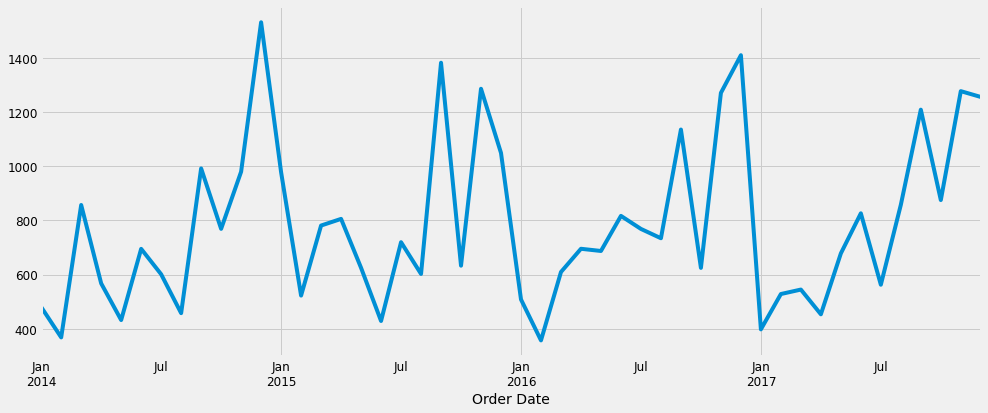

In [9]:
y.plot(figsize=(15, 6))
plt.show()

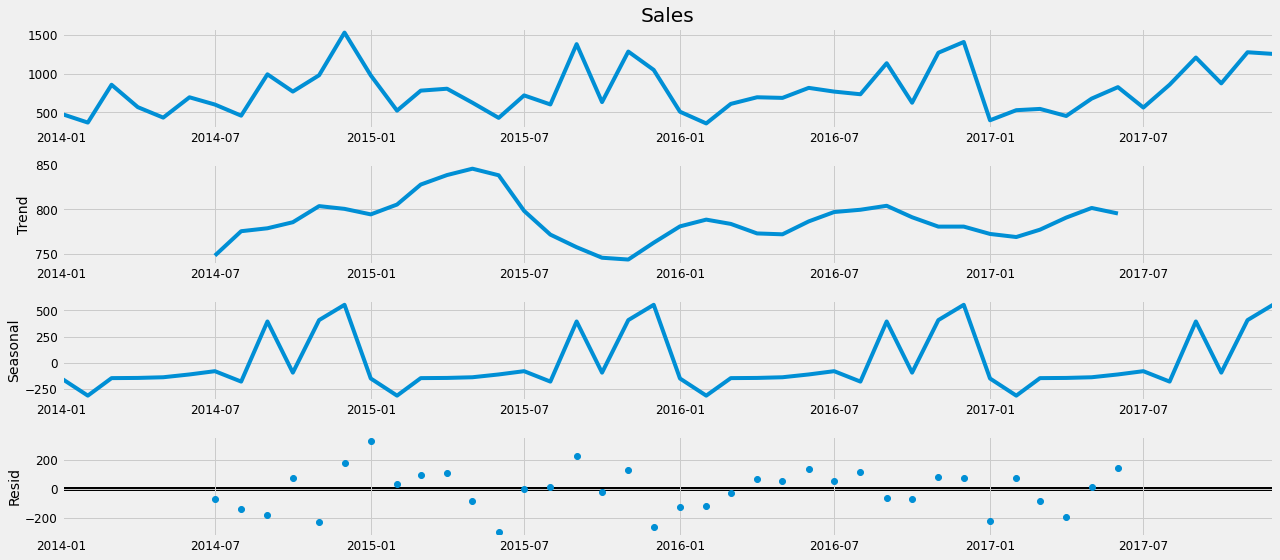

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

## Time series forecasting with ARIMA

In [11]:
#ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [12]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1436.7096275959661
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130920218


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.2702899793748
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.23144334183365


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1131.1862176526117
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.2488280301923
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758111
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2677.925835775167
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.56074298091534
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.6261389673292


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.5890624047003
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2513.2838482013117
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.98848769468657
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.8725576517064
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1508.9266604104025
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.63785672412575


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:304.9671228167959
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.7889663004408


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1149.5499677033372
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:306.91132001514507
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.905617681705
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2473.773079730609


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.87055484827016
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:279.58062333331
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.1832977442572


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2043.7836500817593
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:310.7574368417235
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:281.5576621461254
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:692.1645522067712


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1454.9917424865482
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:479.4632147852136
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:304.2077675160981
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:480.9259367935207


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1116.0873470930849
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:304.4664675084567
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:304.58426921438513
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:665.7794442185518
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:499.86752112528245


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:468.3685195814996
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:293.3422193965892
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:482.5763323876921
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2417.1859846330235


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:306.0156002106262
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:293.7513188122296
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:671.2513547541902


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1407.241863769481
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:479.2003422281134
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:300.2130611619097
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:475.3403658784684
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1340.5016224330247
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:300.6270901345405
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:302.326499250592
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:649.031801983561
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:460.80620661223827


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:460.4762687610129
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:281.3873006939421
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:469.52503546608574


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2046.2257576681052
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:297.78754395275723
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:283.36610143993516


## Fitting the ARIMA model

In [13]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


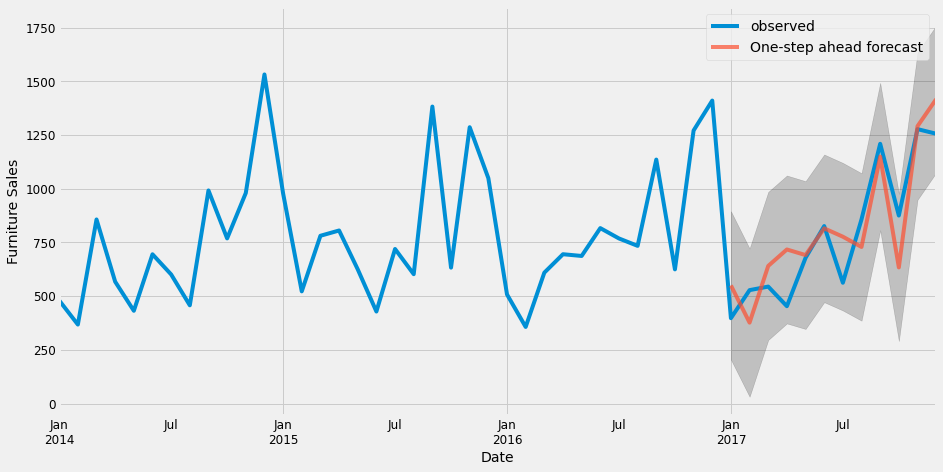

In [17]:
pred=results.get_prediction(start=pd.to_datetime('2017-01-01'),dynamic=False)
pred_ci=pred.conf_int()

ax=y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax,label='One-step ahead forecast', alpha=.7, figsize=(14,7))
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],color='k',alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
              
plt.show()

In [18]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 22993.56


In [19]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 151.64


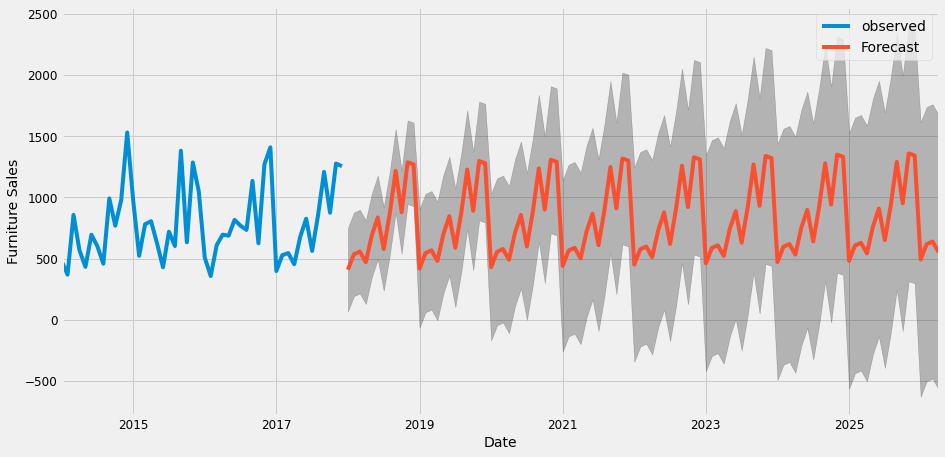

In [20]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()